In [1]:
from transport.greenfunction import GreenFunction
from gpaw import GPAW
from gpaw.lcao.pwf2 import LCAOwrap

calc = GPAW('/home/gag/ownCloud/PTM/nospin/gs.gpw', txt=None)
lcao = LCAOwrap(calc)

H = lcao.get_hamiltonian()
S = lcao.get_overlap()

H -= calc.get_fermi_level() * S

atoms = calc.atoms

gf0  = GreenFunction(H, S, selfenergies=[])

central_carbon = 22

gf0.get_activespace(calc, central_carbon, key=lambda eig: abs(eig)<3)

gf0.set(eta=0.25)
gf0.initialize()

/home/gag/anaconda3/lib/python3.7/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


Condition number: 4.1e+04


In [2]:
def hybrid(sigma):
    def inner(z):
        res = np.zeros(len(z), complex)
        for iz_, z_ in enumerate(z):
            res[iz_] = sigma.retarded(z_-1.j*sigma.eta)
        return res
    return inner

sigma = hybrid(gf0.selfenergies[0])

In [3]:
import fit
reload(fit)

<module 'fit' from '/home/gag/Libraries/edpyt/edpyt/fit.py'>

In [9]:
Delta = fit.fit_hybrid(sigma, nbath=10, nmats=100)

         Current function value: 0.000965
         Iterations: 592
         Function evaluations: 15195
         Gradient evaluations: 723


In [10]:
energies = np.arange(-2,2,1e-2)
eta = 0.5 - gf0.selfenergies[0].eta

In [6]:
expected = np.zeros(len(energies), complex)
for e, energy in enumerate(energies):
    expected[e] = gf0.selfenergies[0].retarded(energy+1.j*eta)

In [11]:
computed = Delta(energies+1.j*eta)#gf0.selfenergies[0].eta)

In [28]:
np.savetxt('a.txt', Delta.a)
np.savetxt('b.txt', Delta.b)

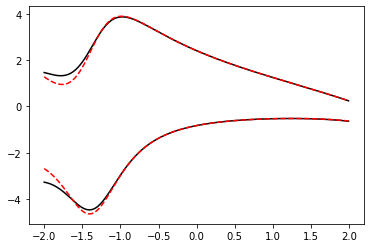

In [29]:
plt.plot(energies, expected.imag, 'k-', energies, computed.imag, 'r--')
plt.plot(energies, expected.real, 'k-', energies, computed.real, 'r--')

In [30]:
n = Delta.a.size + 1
H = np.zeros((n,n))
V = np.zeros((n,n))
mu = np.zeros(n)

In [31]:
H[0,1:] = H[1:,0] = Delta.b
for i in range(1,n):
    H[i,i] = Delta.a[i-1]

In [32]:
U = 0.
V[0,0] = U
H[0,0] = gf0.H + U/2

In [36]:
from gf_lanczos import build_gf_lanczos
from espace import build_espace
from lookup import get_sector_index

In [37]:
nup = ndw = 6
neig_sector = np.zeros((n+1)*(n+1),int)
neig_sector[get_sector_index(nup,ndw,n)] = 1

In [38]:
eigen_space, egs = build_espace(H, V, neig_sector)

In [39]:
gf = build_gf_lanczos(H, V, eigen_space, 0.)

In [40]:
energies = np.arange(-2,2,1e-2)

In [41]:
eta = 0.25

In [42]:
dos = -1/np.pi*gf(energies, eta).imag

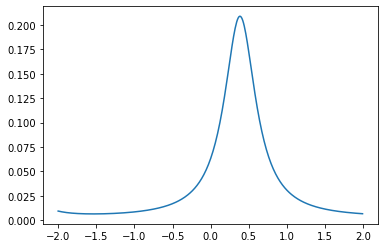

In [43]:
plt.plot(energies, dos)

In [55]:
class SelfEnergyWrap:
    def __init__(self, Delta, eta):
        self.Delta = Delta
        self.eta = eta
    def retarded(self, energy):
        z = np.array(energy+1.j*eta,ndmin=1)
        return np.array(Delta(z),ndmin=2)

In [56]:
selfenergy = SelfEnergyWrap(Delta, 1e-5)

In [57]:
gf0.selfenergies[0] = selfenergy

In [58]:
def get_dos0(energies, gf0):
    dos = np.zeros(len(energies))
    for e, energy in enumerate(energies):
        dos[e] = -1/np.pi*gf0.retarded(energy).imag
    return dos

dos0 = get_dos0(energies, gf0)

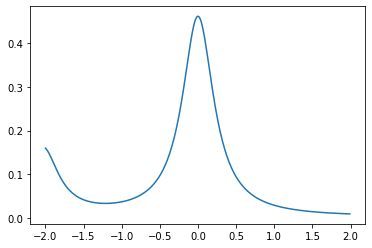

In [59]:
plt.plot(energies, dos0)